In [ ]:
!echo "Please upload your API info"
from google.colab import files
files.upload()
!echo "Files Uploaded"

!echo "Creating the kaggle folder"
!mkdir ~/.kaggle

!echo "Copying the api info to the main folder"
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
%cd ~/.kaggle

!echo "Downloading the dataset"
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

!echo "Unziping the dataset"
!unzip \*.zip  && rm *.zip
!echo "Done."

In [8]:
import cv2
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.applications import ResNet101
from keras.models import Model

In [2]:
def Get_dataset(datatype):
    # dataset directory
    directory = os.path.join("/root/.kaggle/Data/", datatype)

    # category file names
    categories = ["NORMAL","PNEUMONIA", "COVID19"]

    # initialize data list
    data = []

    # image width and height
    image_size = 128

    for category in categories:  
        path = os.path.join(directory,category)  
        if category == "COVID19":
          class_num = 1
        else:
          class_num = 0

        for img in tqdm(os.listdir(path)): 
            try:

                # read image
                image_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR) 
              
                # resize the image
                resized_array = cv2.resize(image_array, (image_size, image_size))  
                
                # add image and its category to a a list
                data.append([resized_array, class_num]) 
            
            # just to keep the output clean
            except Exception as e:
                pass
    
    ##shuffle the data
    random.shuffle(data)

    # initialize the lists
    images = []
    labels = []    

    ##split the data as train images and train_labels 
    for features,label in data:
        images.append(features)
        labels.append(label)

    # reshape the arrays
    images = np.array(images).reshape(-1, image_size, image_size, 3)
    labels = np.array(labels)

    # normalize the data
    images = images/255.0

    return images, labels

In [3]:
# get train data
train_images, train_labels = Get_dataset("train")

# get test data
test_images, test_labels = Get_dataset("test")

100%|██████████| 116/116 [00:04<00:00, 28.87it/s]


In [4]:
resnet101 = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=train_images.shape[1:]
)

for layer in resnet101.layers[:]:
    layer.trainable = False


In [5]:
model = Sequential()

# Add the resnet101 convolutional base model
model.add(resnet101)

# Add flatten layer
model.add(Flatten())

# Add dense layer
model.add(Dense(1024, activation='relu'))

# Add dropout layer
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Show the summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 4, 4, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 76,214,657
Trainable params: 33,556,481
Non-trainable params: 42,658,176
_________________________________________________________________


In [7]:
EPOCHS = 10
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

# Train the model
history = model.fit(
      train_images,
      train_labels,
      epochs=EPOCHS,
      batch_size=16,
      verbose=1
)


Epoch 1/10
322/322 [==============================] - 31s 98ms/step - loss: 0.1081 - acc: 0.9648
Epoch 2/10
322/322 [==============================] - 31s 97ms/step - loss: 0.1064 - acc: 0.9638
Epoch 3/10
322/322 [==============================] - 31s 97ms/step - loss: 0.1000 - acc: 0.9662
Epoch 4/10
322/322 [==============================] - 31s 97ms/step - loss: 0.0927 - acc: 0.9683
Epoch 5/10
322/322 [==============================] - 31s 97ms/step - loss: 0.0908 - acc: 0.9703
Epoch 6/10
322/322 [==============================] - 31s 97ms/step - loss: 0.1003 - acc: 0.9666
Epoch 7/10
322/322 [==============================] - 31s 97ms/step - loss: 0.0891 - acc: 0.9679
Epoch 8/10
322/322 [==============================] - 31s 98ms/step - loss: 0.0937 - acc: 0.9699
Epoch 9/10
322/322 [==============================] - 31s 97ms/step - loss: 0.0810 - acc: 0.9705
Epoch 10/10
322/322 [==============================] - 31s 97ms/step - loss: 0.0831 - acc: 0.9710


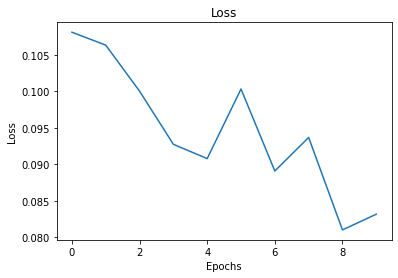

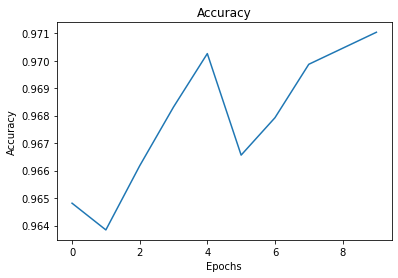

In [10]:
# visualizing losses and accuracy
train_loss = history.history['loss']
train_acc = history.history['acc']

plt.figure()
plt.plot(range(EPOCHS), train_loss)
plt.title('Loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss') 

plt.figure()
plt.plot(range(EPOCHS), train_acc)
plt.title('Accuracy')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 

plt.show()

In [11]:
# Evaluate the model
model.evaluate(test_images, test_labels)

41/41 [==============================] - 6s 135ms/step - loss: 0.0694 - acc: 0.9744


[0.06938910484313965, 0.9743788838386536]